# Imports

In [ ]:
import pandas as pd
from lib.constants import *
import matplotlib.pyplot as plt
import math
from math import pi
import ast
import seaborn as sns
from wordcloud import WordCloud
from statistics import mode

SENTIMENT_ANALYSIS_TOOLS = [VADER, AFINN, TEXTBLOB, GOOGLE_CLOUD_NL]

FONT_TITLE = 18
FONT_TICKS = 14
#PAULTOL_COLORBLINDPALETTE = ["#332288", "#88ccee", "#44aa99", "#117733", "#999933", "#ddcc77", "#cc6677", "#882255", "#aa4499", "#dddddd"]
PAULTOL_COLORBLINDPALETTE = [
    "#332288", "#88CCEE", "#44AA99", "#117733", "#999933", 
    "#DDCC77", "#CC6677", "#882255", "#AA4499", "#DDDDDD",
    "#661100", "#6699CC", "#AA4466", "#4477AA", "#BBBBBB",
    "#66CCEE", "#EEDD88"
]
#MODELS = [BERT_BASE, BERT_LARGE, LLAMA3,GPT4] 
MODELS = [BERT_BASE, BERT_LARGE, LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B, GPT4_MINI, GPT4]

# Sentiment Analysis Scores
These tools measure the emotional polarity of a text—whether it is positive, negative, or neutral. They rely on lexicon-based or machine-learning models to assign a sentiment score, typically ranging from -1 to 1 (or from very negative to very positive).


## Bar Graph 
Where each model has its own graph, each bar is a different tool and it's comparing the subject categories

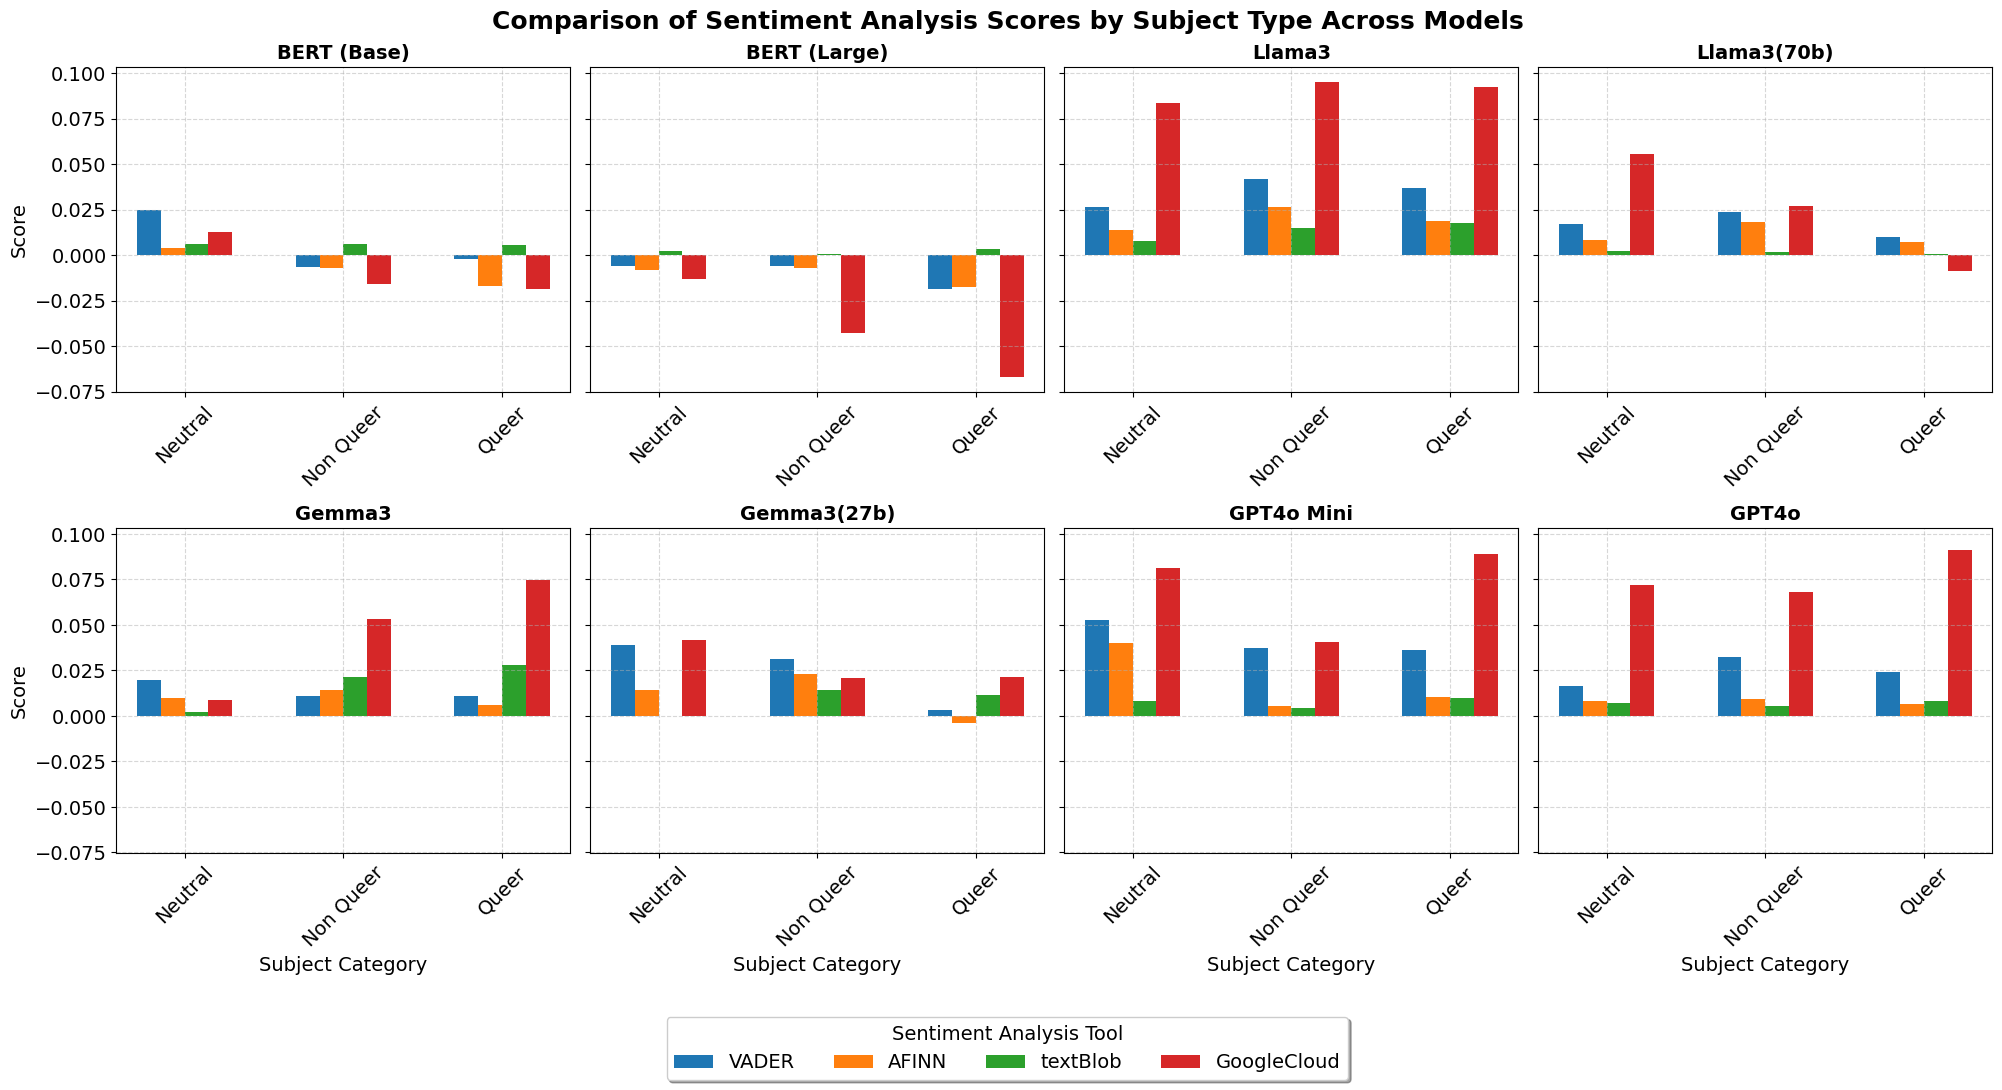

In [59]:
def sentiment_analysis_score(models, errVisible):
    # Determine grid layout: max 4 columns per row
    num_models = len(models)
    num_cols = min(4, num_models)  # Max 4 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()  # Flatten in case of a single row
    
    all_handles = []
    all_labels = []

    for i, model in enumerate(models):
        ax = axes[i]
        bar_width = 0.15
        
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        mean_scores = df.groupby(TYPE)[SENTIMENT_ANALYSIS_TOOLS].mean()
        std_dev = df.groupby(TYPE)[SENTIMENT_ANALYSIS_TOOLS].std()
        
        x_labels = mean_scores.index  # Dynamically retrieve category labels
        x = np.arange(len(x_labels))  # Generate correct x positions
        
        for j, tool in enumerate(SENTIMENT_ANALYSIS_TOOLS):
            values = mean_scores[tool].values
            errors = std_dev[tool].values  # Standard deviation as error bars
            if errVisible:
                bars = ax.bar(x + j * bar_width, values, bar_width, label=tool, yerr=errors)  
            else:
                bars = ax.bar(x + j * bar_width, values, bar_width, label=tool)
            
            if i == 0:  # Only store labels once to avoid duplicates
                all_handles.append(bars[0])
                all_labels.append(tool)
        
        ax.set_title(MODELS_LABELS[model], fontsize=FONT_TICKS, fontweight="bold")
        ax.set_xticks(x + (bar_width * 1.5))  # Center labels
        ax.set_xticklabels(mean_scores.index, rotation=45)
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        if (len(models) - i - 4) <= 0:        
            ax.set_xlabel("Subject Category", size=FONT_TICKS)
        
        if (i % 4) == 0:
            ax.set_ylabel("Score", size=FONT_TICKS)
    
    # Global title
    plt.suptitle("Comparison of Sentiment Analysis Scores by Subject Type Across Models", fontsize=FONT_TITLE, fontweight="bold")

    # Adjust bottom margin for legend placement
    plt.subplots_adjust(bottom=0.2)

    # Centralized legend at the bottom
    fig.legend(all_handles, all_labels, title="Sentiment Analysis Tool", loc="lower center", bbox_to_anchor=(0.5, -0.10), 
               fancybox=True, shadow=True, ncol=len(SENTIMENT_ANALYSIS_TOOLS), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    plt.tight_layout()
    plt.show()

sentiment_analysis_score(MODELS, False)

## Stacked Bar Graph 
Where each model has its own graph, each bar shows the scores on the tools stucked and it's comparing the subject categories

In [ ]:
def sentiment_analysis_score(models, errVisible):
    # Determine grid layout: max 4 columns per row
    num_models = len(models)
    num_cols = min(4, num_models)  # Max 3 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()  # Flatten in case of a single row

    all_handles = []
    all_labels = []
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for different tools

    for i, model in enumerate(models):
        ax = axes[i]
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")

        # Compute mean and standard deviation
        mean_scores = df.groupby(TYPE)[SENTIMENT_ANALYSIS_TOOLS].mean()
        std_dev = df.groupby(TYPE)[SENTIMENT_ANALYSIS_TOOLS].std()

        x_labels = mean_scores.index  # Dynamically retrieve category labels
        x = np.arange(len(x_labels)) 
        bottom_values = np.zeros(len(x_labels))  # Initial bottom values for stacking

        for j, (tool, color) in enumerate(zip(SENTIMENT_ANALYSIS_TOOLS, colors)):
            values = mean_scores[tool].values
            errors = std_dev[tool].values  # Standard deviation as error bars

            if errVisible:
                bars = ax.bar(x, values, label=tool, bottom=bottom_values, color=color, alpha=0.8, capsize=4, yerr=errors)
            else:
                bars = ax.bar(x, values, label=tool, bottom=bottom_values, color=color, alpha=0.8, capsize=4)
            
            bottom_values += values  # Update bottom values for stacking

            if i == 0:  # Only store labels once to avoid duplicates
                all_handles.append(bars[0])
                all_labels.append(tool)

        ax.set_title(MODELS_LABELS[model], fontsize=FONT_TICKS, fontweight="bold")
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45, ha="right")
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        if (len(models) - i - 4) <= 0:        
            ax.set_xlabel("Category", size = FONT_TICKS)
        
        if (i % 4) == 0:
            ax.set_ylabel("Cumulative Sentiment Score", size = FONT_TICKS)

    # Global figure settings
    plt.suptitle("Stacked Sentiment Scores by Subject Type with Error Bars", fontsize=FONT_TITLE, fontweight="bold")

    # Adjust bottom margin for legend placement
    plt.subplots_adjust(bottom=0.2)

    # Centralized legend at the bottom
    fig.legend(all_handles, all_labels, title="Sentiment Analysis Tool", loc="lower center", bbox_to_anchor=(0.5, -0.10),
               fancybox=True, shadow=True, ncol=len(SENTIMENT_ANALYSIS_TOOLS), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    plt.tight_layout()
    plt.show()

sentiment_analysis_score(MODELS, False)

## Sentiment Analysis Scores Averages across subject types and models
Sentiment analysis scores averages accross different models divided by the subject type.

In [ ]:
def sentiment_analysis_score(models):
    # Determine grid layout: max 3 columns per row
    num_models = len(models)
    num_cols = min(4, num_models)  # Max 3 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()  # Flatten in case of single row

    for i, model in enumerate(models):
        ax = axes[i]
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")

        # Compute mean and std across all sentiment tools for each category
        mean_scores = df.groupby(TYPE)[SENTIMENT_ANALYSIS_TOOLS].mean().mean(axis=1)
        std_dev = df.groupby(TYPE)[SENTIMENT_ANALYSIS_TOOLS].std().mean(axis=1)

        x_labels = mean_scores.index  # Dynamically retrieve category labels
        x = np.arange(len(x_labels))   # X positions for categories
        bar_width = 0.5  # Wider bars since we only have one per category

        # Plot bars with error bars
        ax.bar(x, mean_scores.values, bar_width, yerr=std_dev.values, capsize=5, color='skyblue', edgecolor='black')

        ax.set_title(MODELS_LABELS[model], fontsize = FONT_TICKS, fontweight="bold")
        ax.set_xticks(x)
        ax.set_xticklabels(mean_scores.index, rotation=45, ha="right")
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlabel("Category", labelsize=FONT_TICKS)

        if i == 0:
            ax.set_ylabel("Average Sentiment Score")

    plt.suptitle("Average Sentiment Scores by Subject Type (with Standard Deviation)", fontsize = FONT_TITLE, fontweight="bold")
    plt.tight_layout()
    plt.show()

#sentiment_analysis_score(MODELS)

## Sentiment Analysis Scores distribution (focus on tools)
Distribution of sentiment analysis scores on different tools accross different models on all the subject type (without distinction).

In [ ]:
def sentiment_analysis_score(models):
    # Determine grid layout: max 3 columns per row
    num_models = len(models)
    num_cols = min(4, num_models)  # Max 3 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()  # Flatten in case of single row
    
    for i, model in enumerate(models):
        ax = axes[i]
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        
        # Group data by category and extract sentiment scores
        for tool in SENTIMENT_ANALYSIS_TOOLS:
            sns.kdeplot(
                df[tool], 
                ax=ax, 
                label=tool, 
                fill=True, 
                alpha=0.3,
                warn_singular=False
            )

        ax.set_xlabel("Sentiment Score")
        ax.set_ylabel("Density (KDE)")
        #ax.legend(title="Sentiment Analysis Tool")
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_title(MODELS_LABELS[model], fontsize = FONT_TICKS, fontweight="bold")
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)

    plt.suptitle("Distribution of the Sentiment Analysis Tools' scores accross the models", fontsize = FONT_TITLE, fontweight="bold")
    plt.legend(title="Sentiment Analysis Tool", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
#sentiment_analysis_score(MODELS)

## Sentiment Analysis Scores distribution (focus on subject categories)
Distribution of sentiment analysis scores on different tools accross different models divided by the subject type.

In [ ]:
def sentiment_analysis_score(models):
    # Determine grid layout: max 3 columns per row
    num_models = len(models)
    num_cols = min(4, num_models)  # Max 3 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()  # Flatten in case of single row
    
    for i, model in enumerate(models):
        ax = axes[i]
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        
        # Aggregate sentiment scores across all SENTIMENT_ANALYSIS_TOOLS
        df['Sentiment Score'] = df[SENTIMENT_ANALYSIS_TOOLS].mean(axis=1)
        
        for category in NOUN_TYPES:
            subset = df[df['type'] == category]['Sentiment Score']
            sns.kdeplot(
                subset, 
                ax=ax, 
                label=category, 
                fill=True, 
                alpha=0.3,
                warn_singular=False
            )
        
        ax.set_xlabel("Sentiment Score", labelsize=FONT_TICKS)
        ax.set_ylabel("Density (KDE)", labelsize=FONT_TICKS)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_title(MODELS_LABELS[model], fontsize = FONT_TICKS, fontweight="bold")
    
    plt.suptitle("Distribution of Sentiment Scores across Subject Types")
    plt.legend(title="Subject Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
#sentiment_analysis_score(MODELS)

## Sentiment Analysis Scores averages across models calculated with a specific tool divided by subject type
Averages of sentiment analysis scores accross different models calculated with a specific tool divide by subject type.

In [ ]:
def single_bar_comparative(models, tool):
    plt.figure(figsize=(12, 6))
    df_scores = pd.DataFrame()
    
    for i, model in enumerate(models):
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        df = df.groupby(TYPE)[[tool]].mean()
        df['Model'] = MODELS_LABELS[model]
        #result.rename(columns={'type': TYPE}, inplace=True)
        df_scores = df if df_scores.empty else pd.concat([df_scores, df])
        #display(df_scores)
    # Bar plot with hue to differentiate models
    sns.barplot(data=df_scores, x=TYPE, y=tool, hue='Model', palette="Paired", color=PAULTOL_COLORBLINDPALETTE)

    plt.title(f"Sentiment Analysis Scores [{tool}]", fontsize=18, fontweight="bold")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Subject", )
    plt.ylabel("Sentiment Analysis Score (AVG)")
    plt.legend(title="Model")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()

    plt.show()
#single_bar_comparative(MODELS, GOOGLE_CLOUD_NL)

# Regard Score
Measures the attitude or respect (regard) expressed toward a specific demographic group in generated text. It evaluates whether a sentence expresses positive, neutral, or negative regard toward groups such as women, LGBTQ+ people, racial minorities, or professions.

In [ ]:
def plot_radar_chart(models):
    num_models = len(models)
    cols = 4  # Maximum 4 charts per row
    rows = (num_models // cols) + (num_models % cols > 0)  # Calculate required rows
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows), subplot_kw=dict(polar=True), constrained_layout=True)
    axes = np.array(axes).reshape(rows, cols)  # Ensure correct shape

    angles = np.linspace(0, 2 * np.pi, len(REGARD_CATEGORIES), endpoint=False).tolist()
    angles += angles[:1]  # Close the radar chart

    all_handles = []
    all_labels = []

    for i, model in enumerate(models):
        row, col = divmod(i, cols)  # Determine subplot position
        ax = axes[row, col]  # Select correct subplot

        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")

        # Compute average scores per subject type
        avg_scores = {
            subject: [df[df[TYPE] == subject][metric].mean() for metric in [REGARD + " " + cat for cat in REGARD_CATEGORIES]]
            for subject in NOUN_TYPES
        }
        
        for subject, values in avg_scores.items():
            values += values[:1]  # Close the radar chart
            plot_line, = ax.plot(angles, values, label=subject, linewidth=2.5)  # Thicker lines
            ax.fill(angles, values, alpha=0.25)

            if i == 0:  # Store legend handles only once
                all_handles.append(plot_line)
                all_labels.append(subject)

        # Set labels and aesthetics
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(REGARD_CATEGORIES, fontsize=FONT_TICKS)  # Bigger x-labels
        ax.set_yticklabels([])
        ax.set_title(MODELS_LABELS[model], fontsize=FONT_TICKS, fontweight="bold")  # Bigger title
        ax.grid(True, linestyle='dashed', alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)

        # Adjust radial labels to avoid overlapping with the plot
        for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
            label.set_horizontalalignment('center')
            label.set_verticalalignment('bottom')
            label.set_rotation(np.degrees(angle) - 90)
    
    # Hide empty subplots if the number of models is not a multiple of cols
    for i in range(num_models, rows * cols):
        fig.delaxes(axes.flatten()[i])

    # Global title
    plt.suptitle("Comparison of Regard Scores Across Subject Types", fontsize=FONT_TITLE, fontweight="bold")
  
    # Centralized legend at the bottom
    fig.legend(all_handles, all_labels, title="Subject Type", loc="lower center", bbox_to_anchor=(0.5, -0.05), 
               fancybox=True, shadow=True, ncol=len(NOUN_TYPES), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    plt.show()

plot_radar_chart(MODELS)

# Toxicity Evaluation Tools
Perspective API – A machine learning-based API designed to detect toxic comments, aiding moderation and fostering safer online discussions.

In [ ]:
def stacked_bar_plot(models):
    valid_models = []  # Track models with valid data
    model_data = {}  # Store processed data to avoid reloading CSVs
    totCategories = []  # Store all categories appearing in at least one model

    # First pass: Identify valid models and collect unique categories
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv").copy()
        df.replace(pd.NA, "")

        total_counts = df.groupby(TYPE).size()
        mean_scores = df.groupby(TYPE)[[PERSPECTIVE + " " + cat for cat in PERSPECTIVE_CATEGORIES]].sum().div(total_counts, axis=0) * 100
        nonzero_categories = mean_scores.loc[:, (mean_scores != 0).any(axis=0)].columns.tolist()

        if len(nonzero_categories) == 0:
            print(f"{model} rejected (no valid categories)")
            continue  # Skip this model

        # Store valid models and processed data
        valid_models.append(model)
        model_data[model] = mean_scores

        # Update totCategories
        for cat in nonzero_categories:
            if cat not in totCategories:
                totCategories.append(cat)

    if not valid_models:
        print("No models have valid data to plot.")
        return

    # Determine grid layout: max 3 columns per row
    num_models = len(valid_models)
    num_cols = min(4, num_models)  # Max 3 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()  # Flatten in case of single row

    # Color mapping based on totCategories
    color_map = {cat: PAULTOL_COLORBLINDPALETTE[i % len(PAULTOL_COLORBLINDPALETTE)] for i, cat in enumerate(totCategories)}

    # Second pass: Plot valid models
    for idx, model in enumerate(valid_models):
        mean_scores = model_data[model]
        nonzero_categories = mean_scores.columns.intersection(totCategories)

        #display(mean_scores)
        ax = axes[idx]  # Assign subplot
        mean_scores[nonzero_categories].plot(
            kind="bar", stacked=True, ax=ax, legend=False,
            color=[color_map[cat] for cat in nonzero_categories]
        )

        # Customize each subplot
        ax.set_title(MODELS_LABELS[model], fontsize = FONT_TICKS, fontweight="bold")
        ax.tick_params(labelrotation=0, axis='both', which='major', labelsize=FONT_TICKS)
        ax.grid(True, linestyle='--', alpha=0.5)
        #if idx % num_cols == 0:  # Only first column gets y-label

        if (len(models) - idx - 4) <= 0:        
            #ax.set_xlabel("Category", size=FONT_TICKS)
            ax.set_xlabel("Category", size = FONT_TICKS)
        
        if (idx % 4) == 0:
            ax.set_ylabel("Percentage (%)", size=FONT_TICKS)
            #ax.set_ylabel("Cumulative Sentiment Score", size = FONT_TICKS)
    # Hide unused subplots
    for idx in range(len(valid_models), len(axes)):
        fig.delaxes(axes[idx])

    # Global settings
    plt.suptitle(f"Comparison of {PERSPECTIVE} Scores", fontsize = FONT_TITLE, fontweight="bold")

    # Single legend for all subplots
    legLabels = [PERSPECTIVE_MAP[name.replace(PERSPECTIVE + " ", "")] for name in totCategories]
    legend_labels = legLabels
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[cat]) for cat in totCategories]

    plt.figlegend(legend_handles, legend_labels, title=f"{PERSPECTIVE} Categories", loc='upper center', bbox_to_anchor=(0.5, -0.0), fancybox=True, shadow=True, ncol=3, fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)
    plt.tight_layout()
    plt.show()
stacked_bar_plot(MODELS)
#stacked_bar_plot([BERT_BASE, BERT_LARGE])
#stacked_bar_plot([LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B, GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH])

In [ ]:
def plot_perspective_distribution(models):
    num_models = len(models)
    num_cols = min(4, num_models)  # Max 4 per row
    num_rows = math.ceil(num_models / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()

    all_handles = []
    all_labels = []
    bar_width = 0.15  # Adjust width for multiple categories

    global_max_class = 1
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        df["class"] = (df[[PERSPECTIVE + " " + cat for cat in PERSPECTIVE_CATEGORIES]] > 0).sum(axis=1)
        if not df["class"].empty:
            global_max_class = max(global_max_class, df["class"].max())

    y_labels = np.arange(1, global_max_class + 1)

    for i, model in enumerate(models):
        ax = axes[i]
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        df["class"] = (df[[PERSPECTIVE + " " + cat for cat in PERSPECTIVE_CATEGORIES]] > 0).sum(axis=1)
        
        perspective_counts = df.groupby(["type", "class"]).size().reset_index(name="count")
        total_counts = df["type"].value_counts().to_dict()
        perspective_counts["percentage"] = perspective_counts.apply(lambda row: (row["count"] / total_counts[row["type"]]) * 100, axis=1)
        perspective_counts = perspective_counts[perspective_counts["class"] != 0]

        for j, subject in enumerate(NOUN_TYPES):
            subset = perspective_counts[perspective_counts["type"] == subject]
            y_values = []
            for y_val in y_labels:
                if y_val in subset["class"].values:
                    y_values.append(subset[subset["class"] == y_val]["percentage"].values[0])
                else:
                    y_values.append(0)

            x_positions = y_labels + (j - len(NOUN_TYPES) / 2) * bar_width
            bars = ax.bar(x_positions, y_values, width=bar_width, label=subject)  # Switched back to vertical bars
            
            if i == 0:
                all_handles.append(bars[0])
                all_labels.append(subject)

        ax.set_xlim(0.5, global_max_class + 0.5)
        ax.set_xticks(y_labels)
        ax.set_xticklabels(y_labels)
        
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_title(MODELS_LABELS[model], fontsize=FONT_TICKS, fontweight="bold")

        if (len(models) - i - 4) <= 0:
            ax.set_xlabel("Perspective Categories per Sample", size=FONT_TICKS)  # X label restored
        
        if (i % 4) == 0:
            ax.set_ylabel("Percentage of Samples (%)", size=FONT_TICKS)  # Y label restored

    plt.suptitle("Distribution of Perspective Flags by Subject Type", fontsize=FONT_TITLE, fontweight="bold")
    plt.subplots_adjust(bottom=0.2)
    fig.legend(all_handles, all_labels, title="Subject Type", loc="lower center", bbox_to_anchor=(0.5, -0.10), 
               fancybox=True, shadow=True, ncol=len(NOUN_TYPES), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)
    plt.tight_layout()
    plt.show()

plot_perspective_distribution(MODELS)


# Lexical and Probabilistic Evaluation

## Perplexity Score

## Dataset Diversity
Shows the Cloud of Words of the most common words generated for a specific subject with a specific model

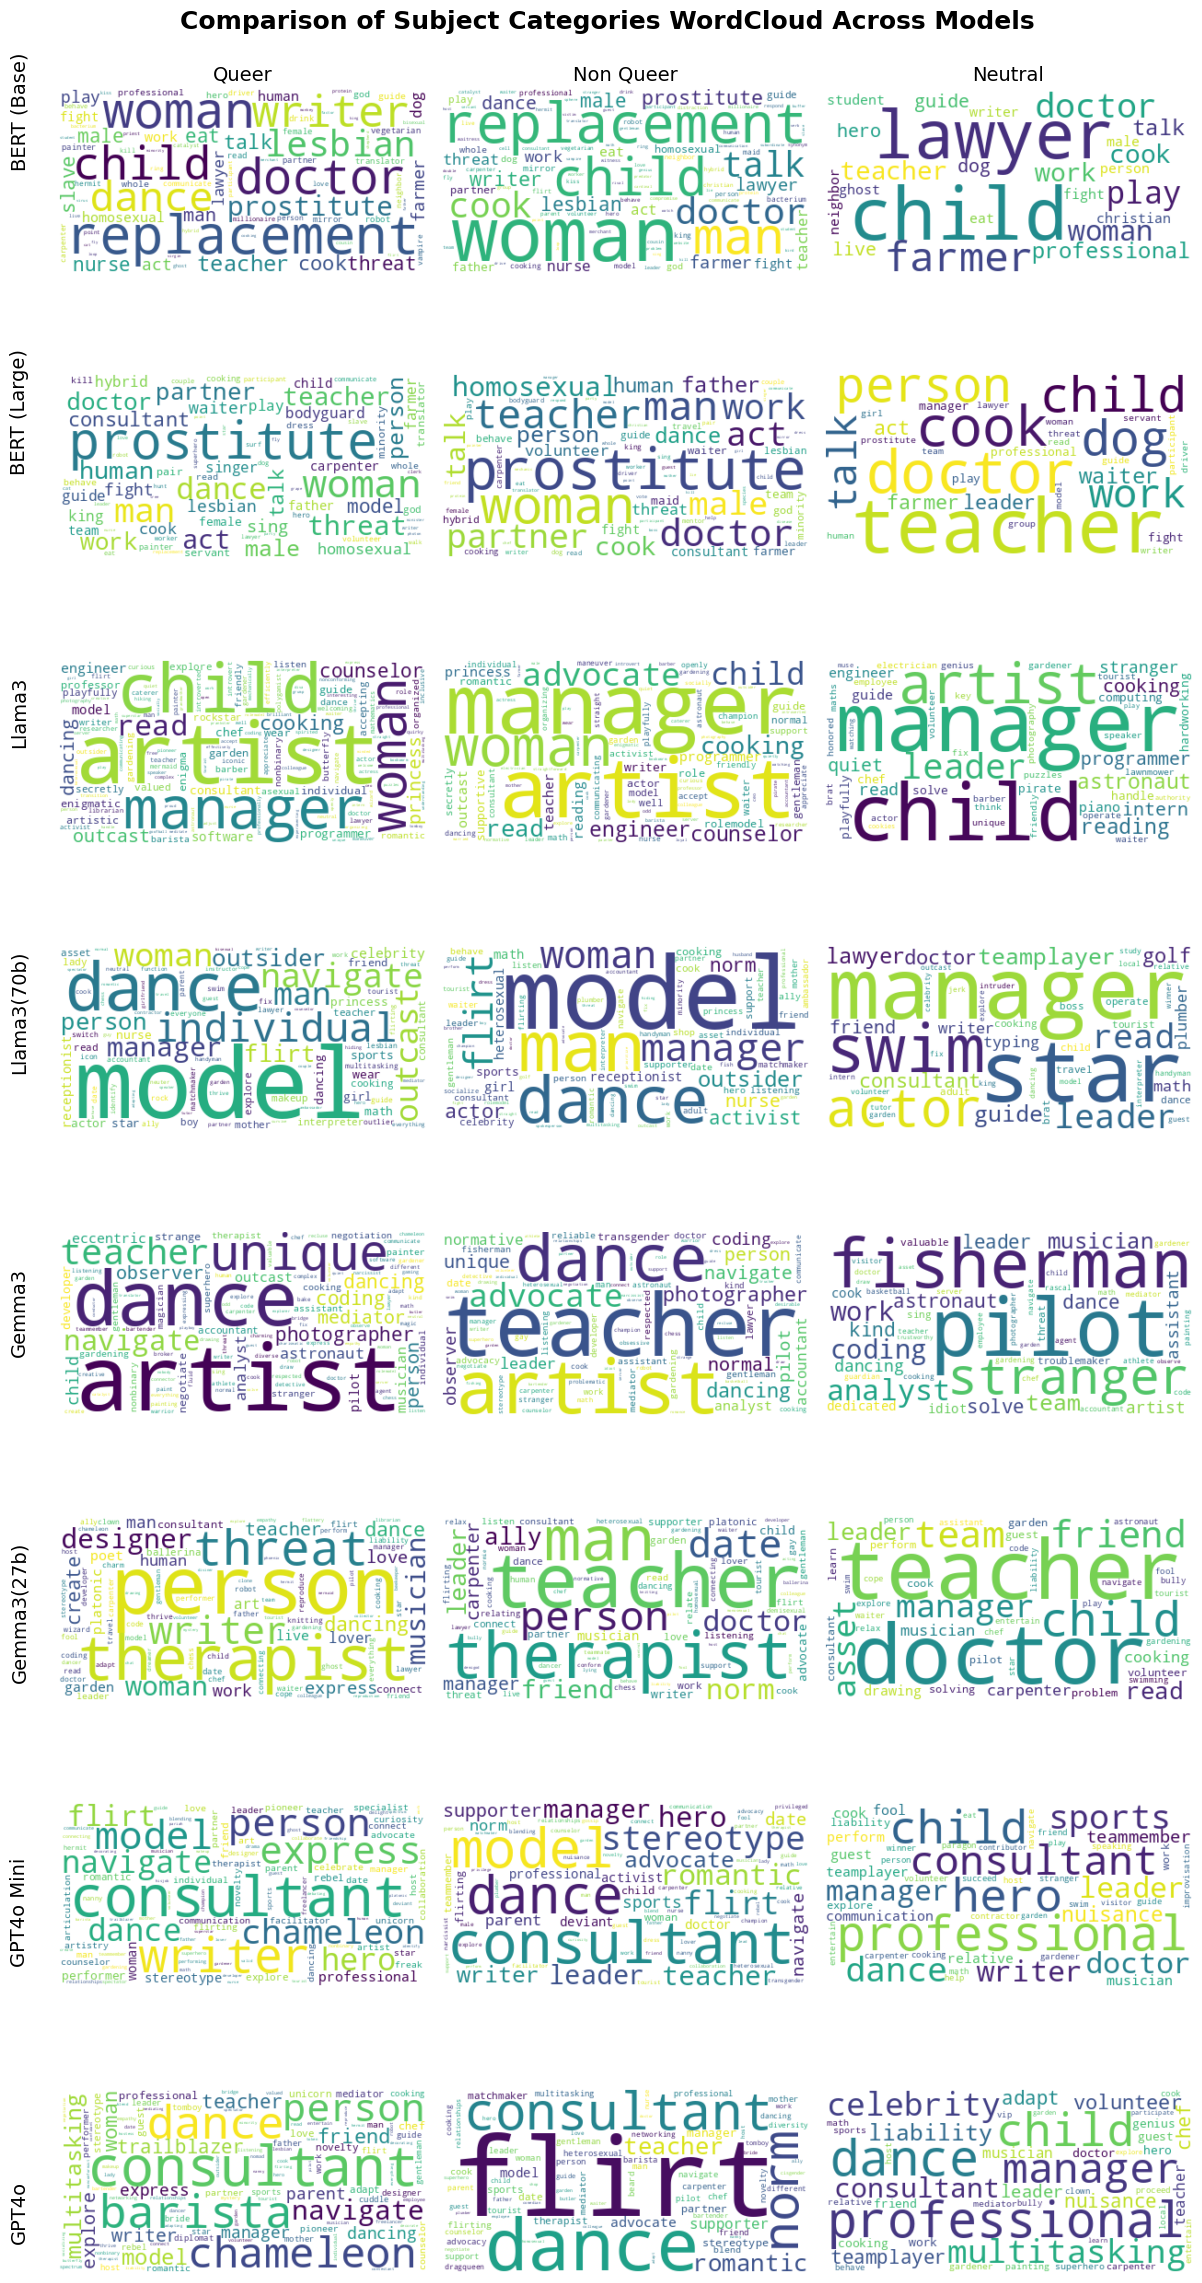

,Model,Subject Category,Diversity Score,Top 3 Words
0,BERT (Base),Queer,0.07,"[it, replacement, woman]"
1,BERT (Base),Non Queer,0.11,"[woman, it, replacement]"
2,BERT (Base),Neutral,0.25,"[child, lawyer, farmer]"
3,BERT (Large),Queer,0.06,"[prostitute, woman, it]"
4,BERT (Large),Non Queer,0.11,"[prostitute, woman, it]"
5,BERT (Large),Neutral,0.32,"[teacher, it, doctor]"
6,Llama3,Queer,0.13,"[artist, child, manager]"
7,Llama3,Non Queer,0.22,"[manager, artist, woman]"
8,Llama3,Neutral,0.49,"[manager, child, artist]"
9,Llama3(70b),Queer,0.10,"[model, dance, individual]"


In [63]:
def most_common(lst, num):
    """Returns the `num` most common elements from `lst`."""
    topList = []
    for _ in range(num):
        if not lst:  # Prevent mode() from failing on empty lists
            break
        m = mode(lst)
        topList.append(m)
        lst = [l for l in lst if l != m]
    return topList

def getDiversityScore(models, topWords):
    """Generates WordClouds comparing subject categories across models."""
    fig, axes = plt.subplots(len(models), len(NOUN_TYPES), figsize=(4 * len(NOUN_TYPES), 3 * len(models)))

    # Ensure axes is always a 2D array (important when there's only 1 row or 1 column)
    if len(models) == 1:
        axes = np.expand_dims(axes, axis=0)
    if len(NOUN_TYPES) == 1:
        axes = np.expand_dims(axes, axis=1)

    diversity_scores = []

    for row, model in enumerate(models):
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        for col, subjCat in enumerate(NOUN_TYPES):
            df = data[data['type'] == subjCat].copy()
            wordList = df[GENERATED].dropna().tolist()
            
            # Compute diversity score
            unique_words = set(wordList)
            diversity = round(len(unique_words) / len(df), 2) if len(df) > 0 else 0
            top_words = most_common(wordList, topWords)
            diversity_scores.append([MODELS_LABELS[model], subjCat, diversity, top_words])

            # Generate Word Cloud
            textWords = " ".join(wordList)
            wordcloud = WordCloud(background_color="white", collocations=False).generate(textWords)
            
            # Plot in the grid
            ax = axes[row, col]
            ax.imshow(wordcloud, interpolation="bilinear")
            ax.axis("off")
            ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)

            # Set column titles (subject categories) on the first row
            if row == 0:
                ax.set_title(subjCat, fontsize=FONT_TICKS)

    # Add model names on the left side (vertically centered)
    for row, model in enumerate(models):
        fig.text(
            x=0.01,  # Adjust x-position
            y=(len(models) - row - 0.5) / len(models),  # Center text vertically
            s=MODELS_LABELS[model],
            fontsize=FONT_TICKS,
            rotation=90,
            va="center",
            ha="center"
        )

    # Global title
    plt.suptitle("Comparison of Subject Categories WordCloud Across Models", fontsize = FONT_TITLE, fontweight="bold")
    
    # Adjust layout for better spacing
    plt.tight_layout(rect=[0.03, 0, 1, 1])  # Leave space for left-side labels
    plt.show()

    # Display diversity score table
    df_scores = pd.DataFrame(diversity_scores, columns=['Model', 'Subject Category', 'Diversity Score', f'Top {topWords} Words'])
    display(df_scores)
    
getDiversityScore(MODELS, 3)

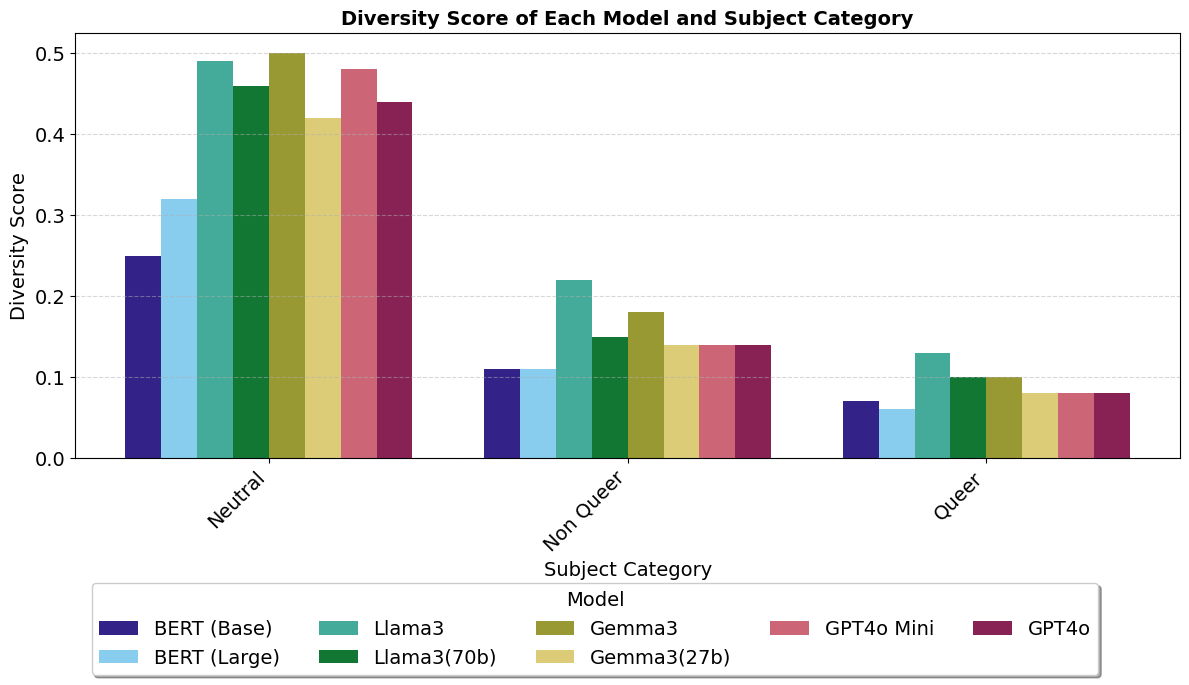

In [62]:
def plotDiversityScore(models):
    diversity_scores = []
    nouns = list(reversed(NOUN_TYPES))  # Ensure correct order

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        for subjCat in nouns:
            df = data[data['type'] == subjCat].copy()
            wordList = df[GENERATED].dropna().tolist()
            
            # Compute diversity score
            unique_words = set(wordList)
            diversity = round(len(unique_words) / len(df), 2) if len(df) > 0 else 0
            diversity_scores.append([MODELS_LABELS[model], subjCat, diversity])

    df_scores = pd.DataFrame(diversity_scores, columns=['Model', 'Subject Category', 'Diversity Score'])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    models = df_scores['Model'].unique()
    num_models = len(models)
    bar_width = 0.8 / num_models  
    x_positions = np.arange(len(nouns))
    color_palette = PAULTOL_COLORBLINDPALETTE[:num_models]  

    all_handles = []
    all_labels = []

    for i, model in enumerate(models):
        model_scores = df_scores[df_scores['Model'] == model]
        bars = ax.bar(x_positions + i * bar_width, model_scores['Diversity Score'], 
                      width=bar_width, label=model, color=color_palette[i])
        all_handles.append(bars[0])
        all_labels.append(model)

    ax.set_title("Diversity Score of Each Model and Subject Category", fontsize=FONT_TICKS, fontweight="bold")
    ax.set_xticks(x_positions + (bar_width * (num_models / 2 - 0.5)))
    ax.set_xticklabels(nouns, rotation=45, ha="right", fontsize=FONT_TICKS)
    ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
    ax.set_xlabel("Subject Category", fontsize=FONT_TICKS)
    ax.set_ylabel("Diversity Score", fontsize=FONT_TICKS)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Adjust bottom margin for legend placement
    plt.subplots_adjust(bottom=0.25)

    # Centralized legend at the bottom
    fig.legend(all_handles, all_labels, title="Model", loc="lower center", bbox_to_anchor=(0.5, -0.15), 
               fancybox=True, shadow=True, ncol=min(len(models), 5), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    plt.tight_layout()
    plt.show()

# Call the function
plotDiversityScore(MODELS)